In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import seaborn as sn
from tqdm import tqdm
from Model_Wrapper import Wrapper
import torch.nn.functional as F
from Datasets import dataset 
from DataLoaders import DataLoader
import helper

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
helper.set_random_seed()

Random seed set to: 13


In [4]:
transform_1 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_2 = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

color_jitter = transforms.ColorJitter(
    brightness=0.4,  # Adjust brightness by ±40%
    contrast=0.4,    # Adjust contrast by ±40%
    saturation=0.4,  # Adjust saturation by ±40%
    hue=0.1          # Adjust hue by ±10%
)

transform_3 = transforms.Compose([
    transforms.Resize((250, 250)),
    color_jitter,
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define a list of different transforms
transformations = [transform_1, transform_2, transform_3]


In [5]:
train_datasets = []
test_datasets = []
for transform in transformations :
    train_ds =dataset(root = "images/",transform=transform, split = "train")
    train_datasets.append(train_ds)
    test_ds =dataset(root = "images/",transform=transform, split = "test")
    test_datasets.append(test_ds)
classes = ("Robots", "Humans")
print(f"train size :{train_ds.__len__()} \n test size :{test_ds.__len__()} ")

train size :339 
 test size :146 


In [6]:
# trainloader = DataLoader(train_ds, batch_size=32, shuffle=True,num_classes = 2,augmentation = "CutMix",alpha = 1.0 )
trainloaders = []
testloaders = []
for train_ds,test_ds in zip(train_datasets,test_datasets):
    trainloader = DataLoader(train_ds, batch_size=32, shuffle=True,num_classes = 2)
    trainloaders.append(trainloader)
    testloader = DataLoader(test_ds, batch_size=32, shuffle=False, num_classes =2 )
    testloaders.append(testloader)

for adv_aug in ["CutMix","MixUp"]:
    trainloader = DataLoader(train_datasets[0], batch_size=32, shuffle=True,num_classes = 2,augmentation = adv_aug,alpha = 1.0 )
    trainloaders.append(trainloader)
    testloader = DataLoader(test_datasets[0], batch_size=32, shuffle=False, num_classes =2 )
    testloaders.append(testloader)
    
class_names = ["Humans", "Robots"]

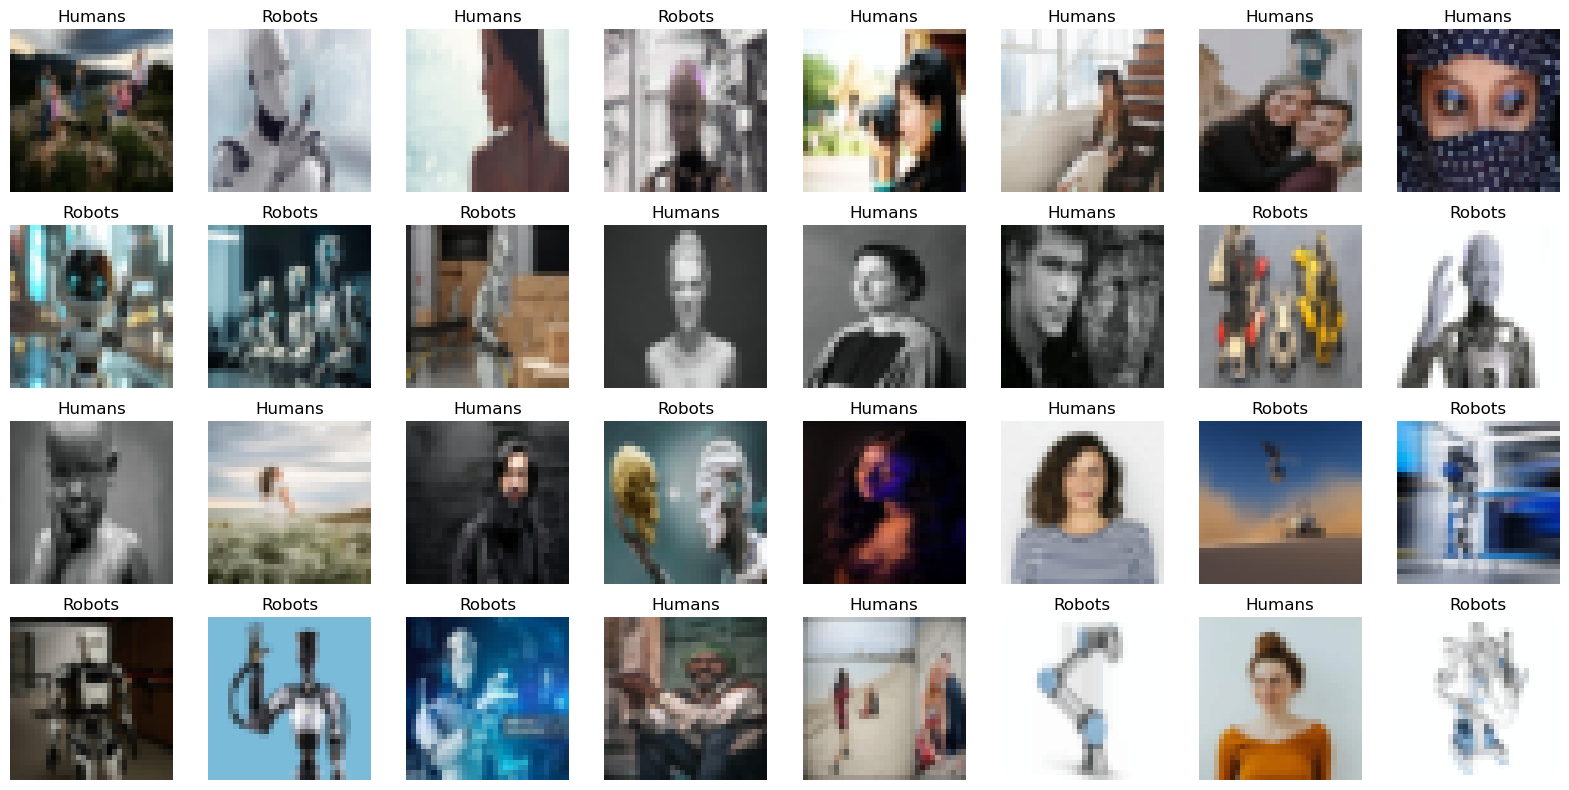

In [7]:
inputs, classes = next(iter(testloader))
titles = [class_names[x] for x in classes]

helper.show_grid(inputs,titles)

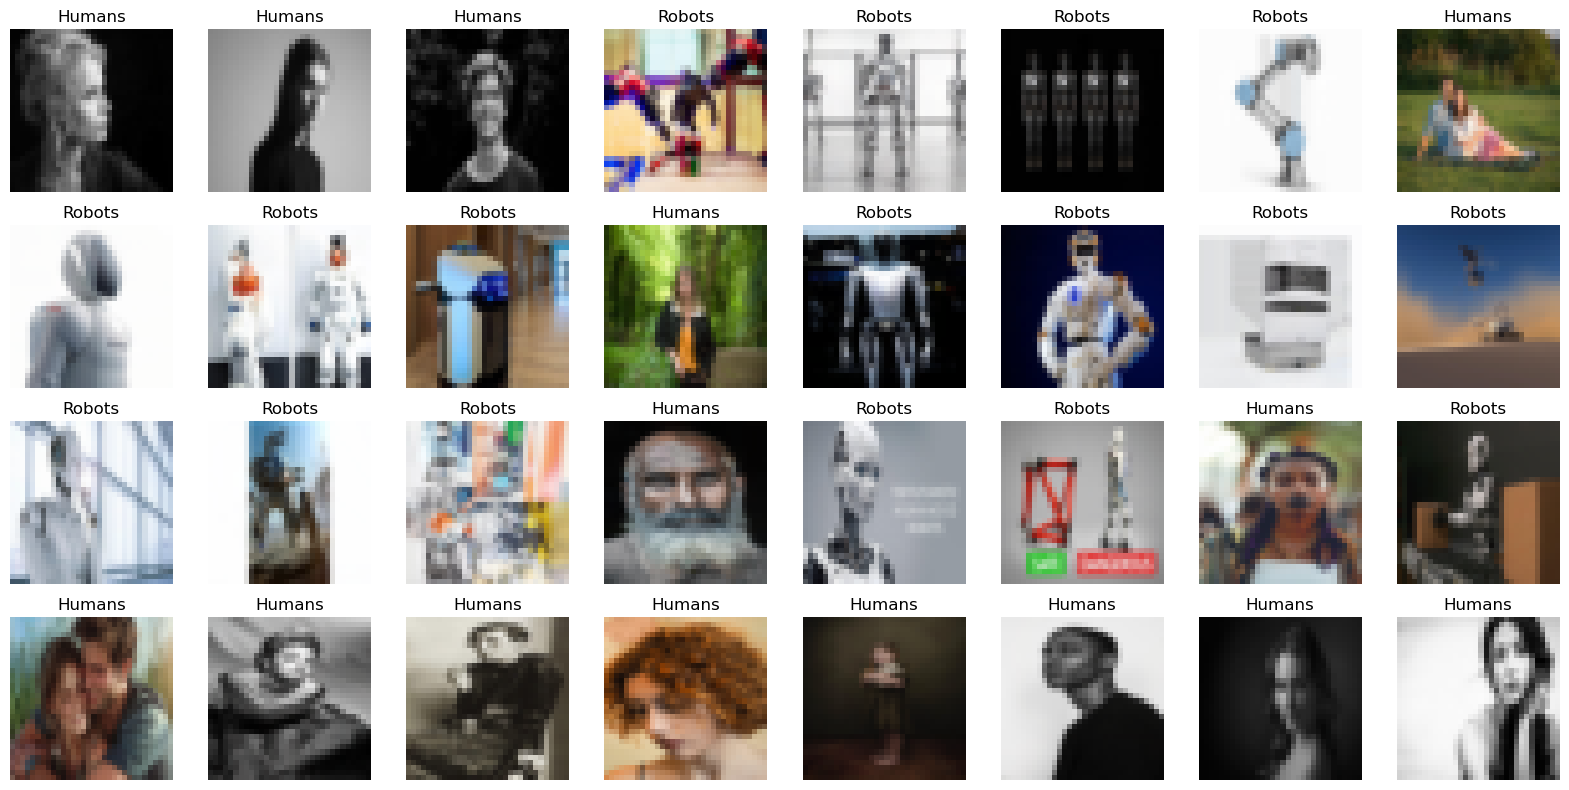

In [8]:
inputs, classes = next(iter(trainloaders[-1]))
titles = [class_names[x] for x in classes.argmax(dim=1)]

helper.show_grid(inputs,titles)


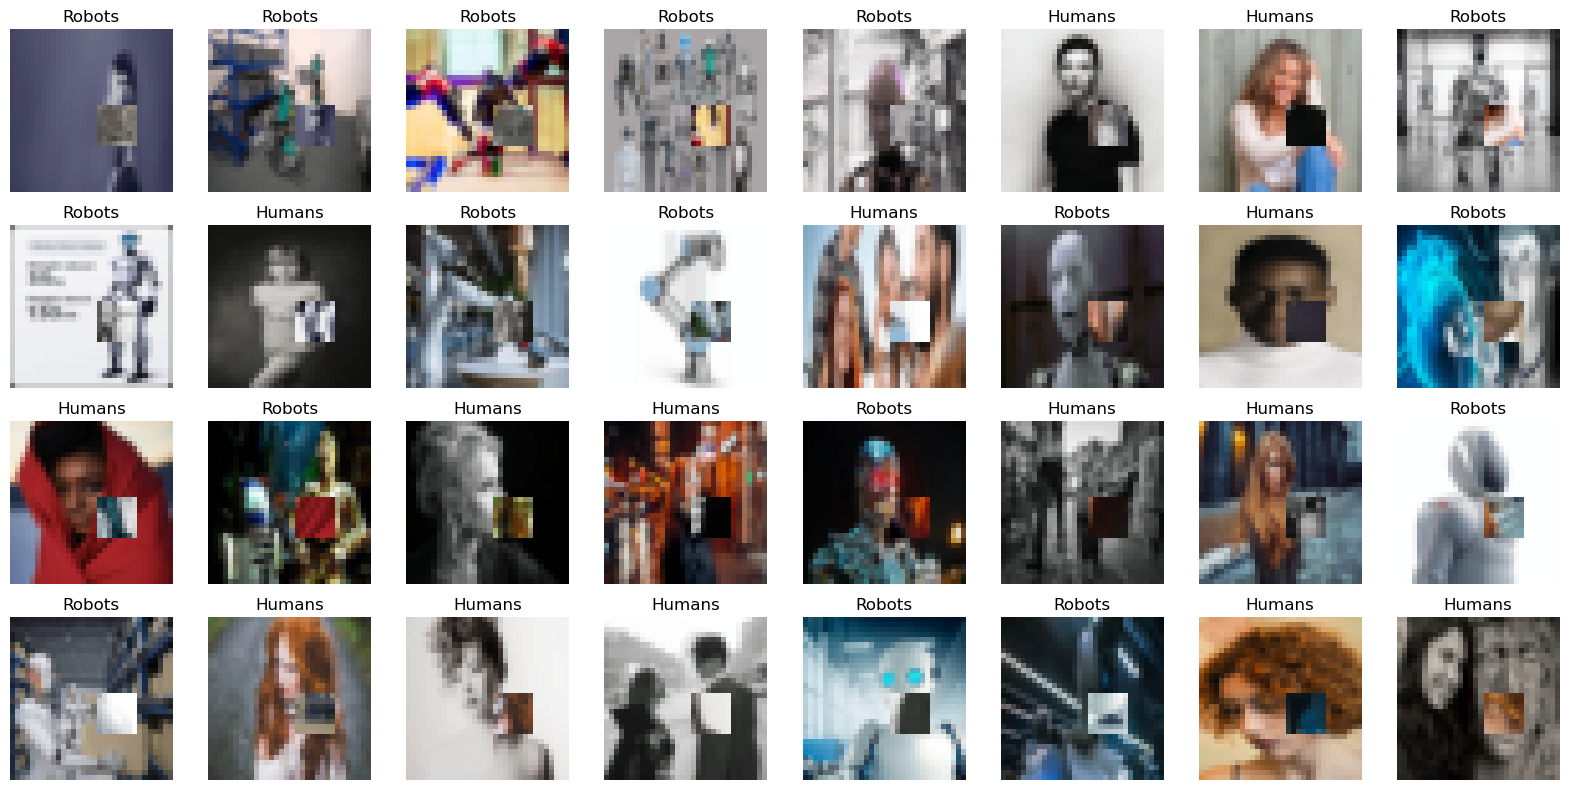

In [9]:
inputs, classes = next(iter(trainloaders[-2]))
titles = [class_names[x] for x in classes.argmax(dim=1)]

helper.show_grid(inputs,titles)


# A) fine tune a model with augmented data  

normalization_only test accuracy : 
Validation accuracy: 88.36%


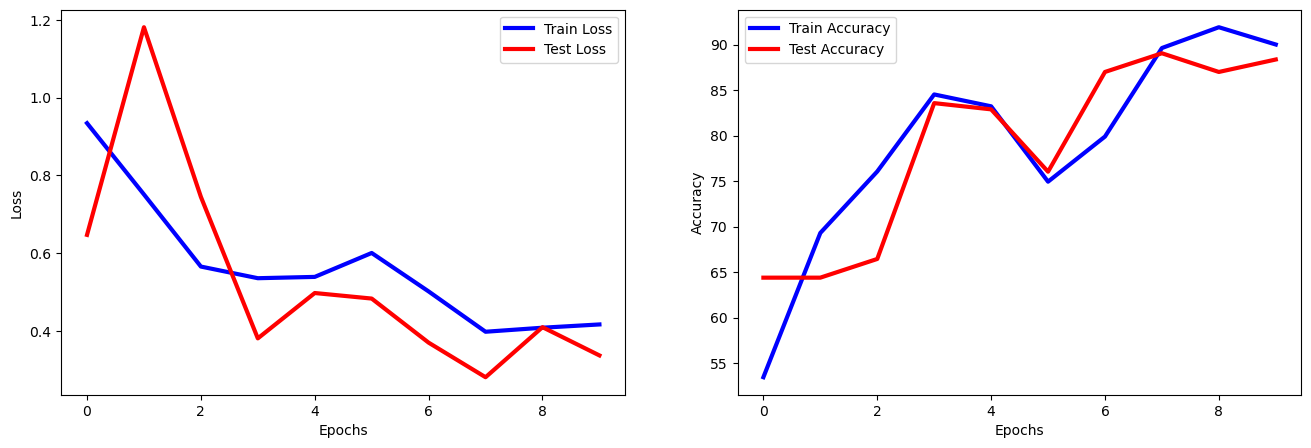

horizontal_flip test accuracy : 
Validation accuracy: 89.04%


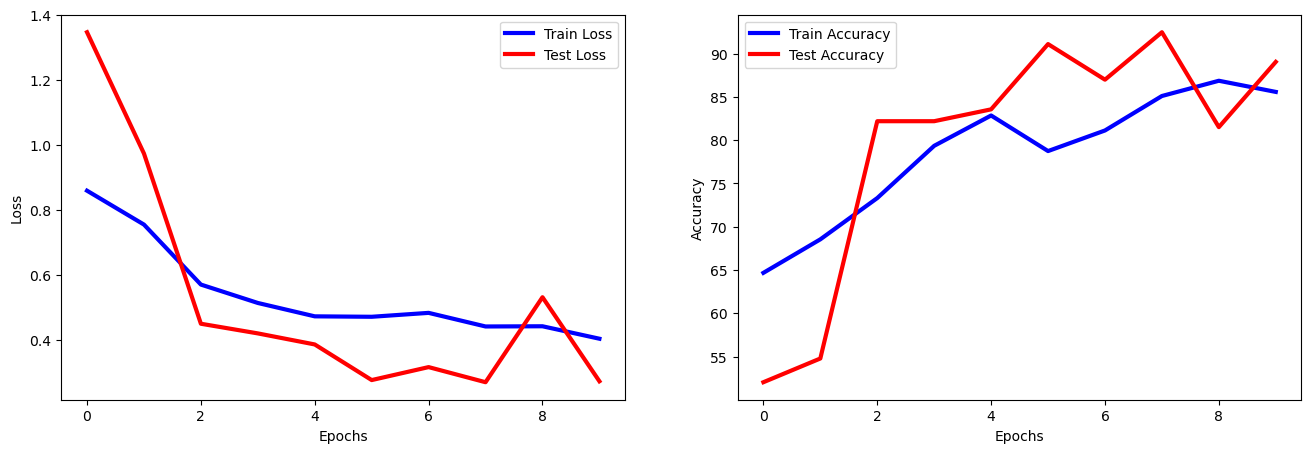

color_jitter test accuracy : 
Validation accuracy: 84.25%


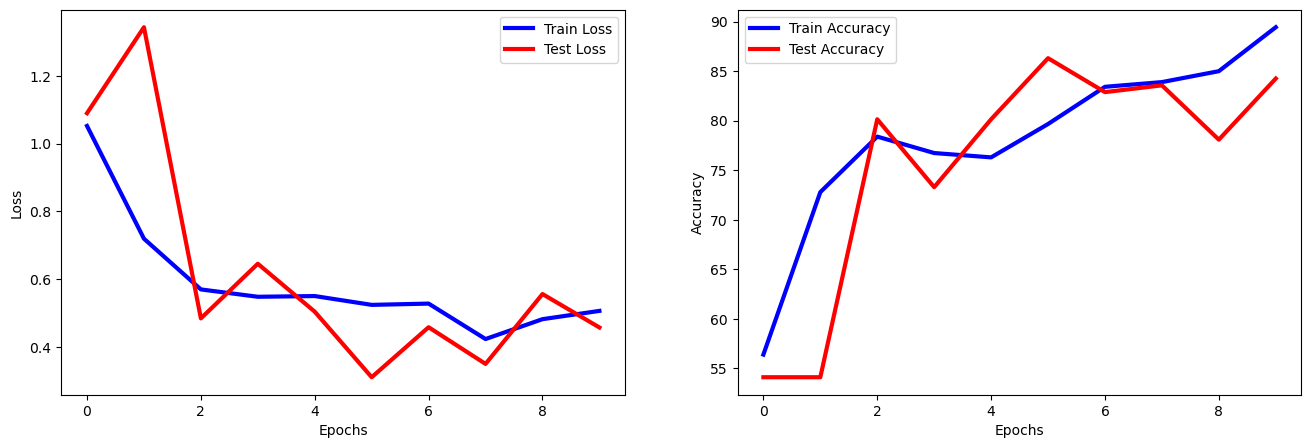

CutMix test accuracy : 
Validation accuracy: 91.1%


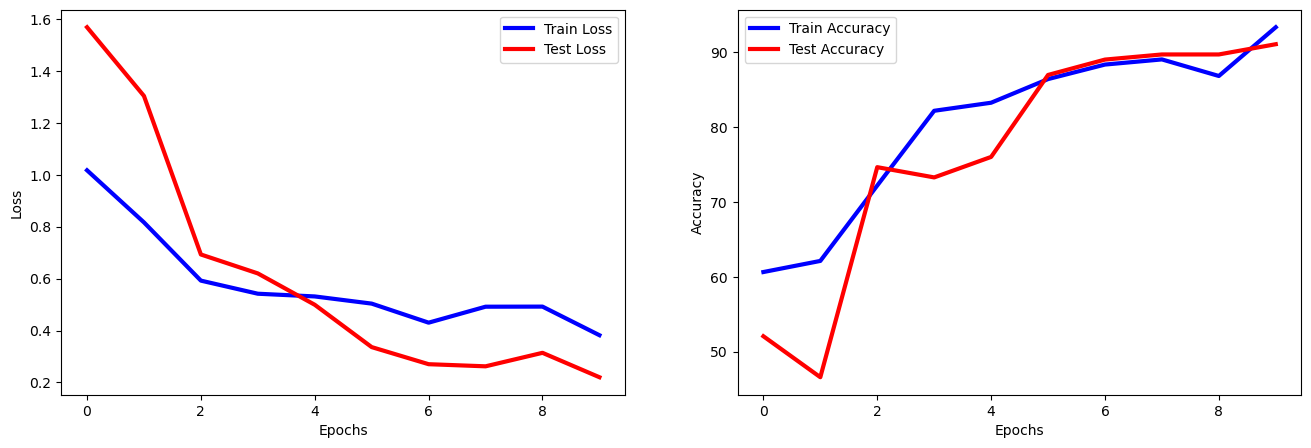

MixUp test accuracy : 
Validation accuracy: 88.36%


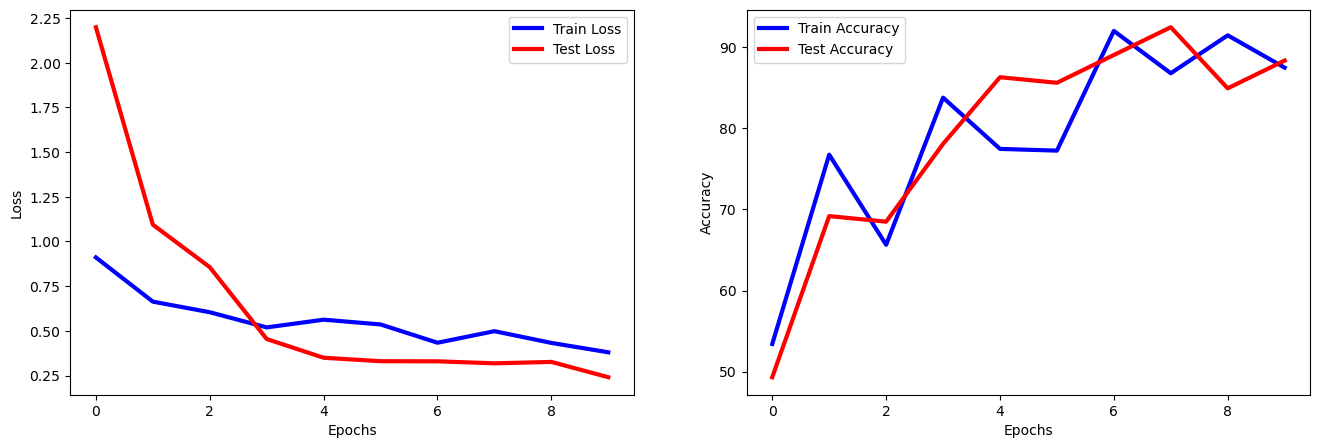

In [10]:
augmentation_type = ["normalization_only","horizontal_flip","color_jitter","CutMix","MixUp"]
for i, (train_loader, test_loader) in enumerate(zip(trainloaders, testloaders)):
    
    writer = helper.new_writer("Resnet18+augmentation", augmentation_type[i])
    
    model = torchvision.models.resnet18(weights = None)
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, 2) 
    
    model.to(device)
    model.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train = Wrapper(model = model,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
    train.train(10,trainloader,testloader,classes)
    print(f"{augmentation_type[i] } test accuracy : ")
    train.valid_accuracy()
    train.plot_loss_acc()
    writer.close()
 

normalization_only test accuracy : 
Validation accuracy: 51.37%


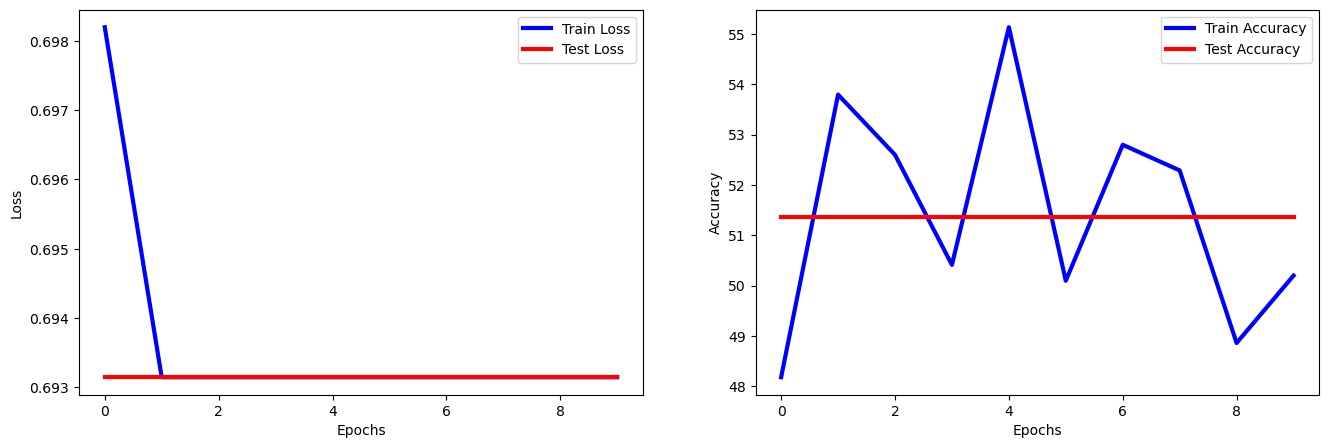

horizontal_flip test accuracy : 
Validation accuracy: 51.37%


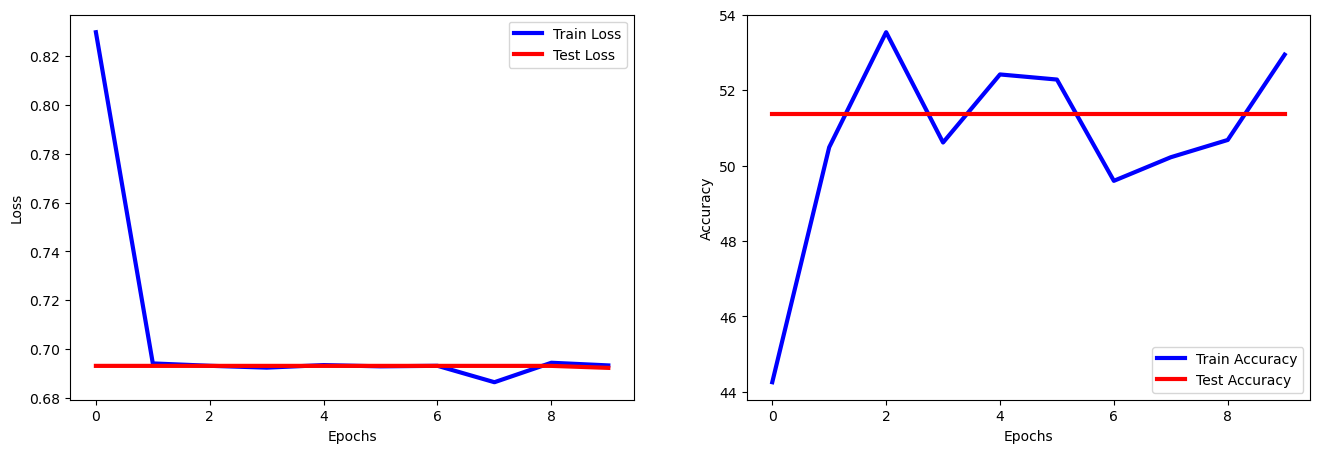

color_jitter test accuracy : 
Validation accuracy: 51.37%


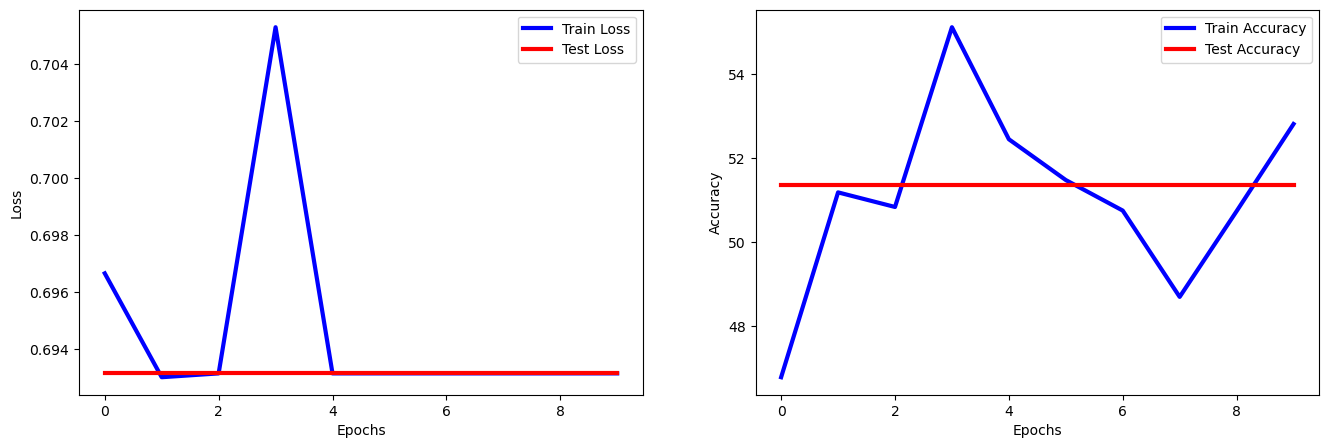

CutMix test accuracy : 
Validation accuracy: 51.37%


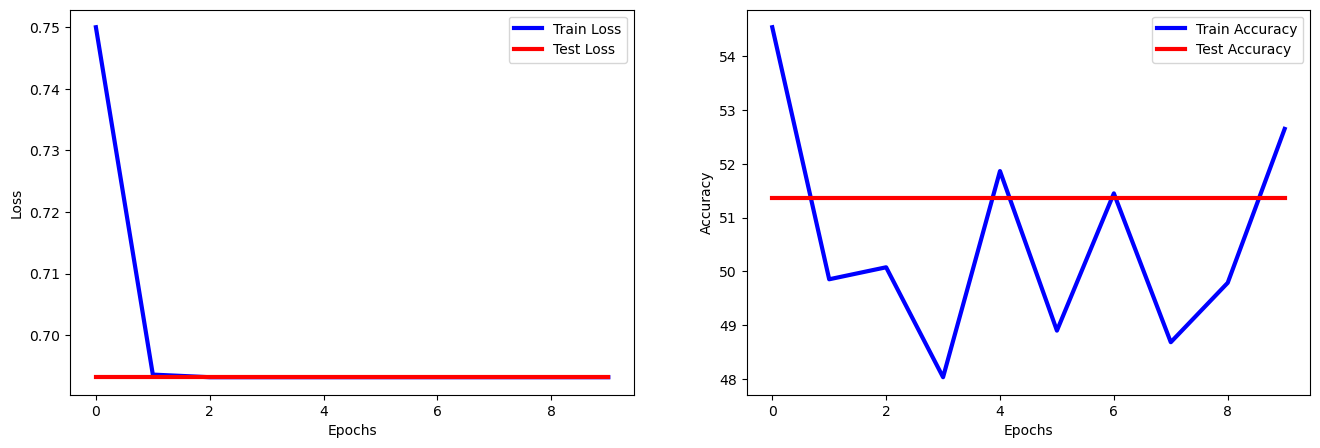

MixUp test accuracy : 
Validation accuracy: 51.37%


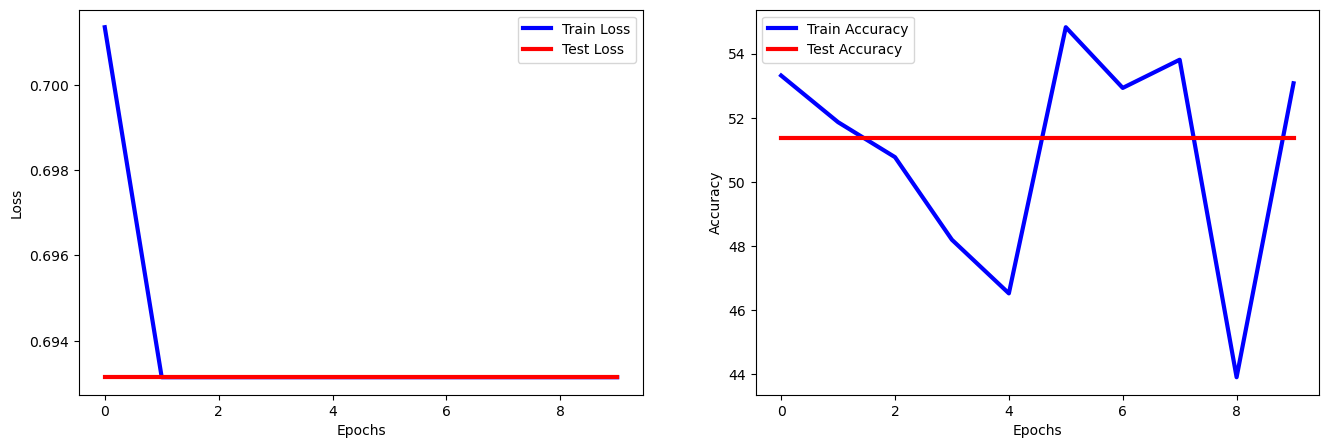

In [11]:
for i, (train_loader, test_loader) in enumerate(zip(trainloaders, testloaders)):
    
    writer = helper.new_writer("SqueezeNet+augmentation", augmentation_type[i])
    
    squeezeNet = torchvision.models.squeezenet1_0(weights = None)
    squeezeNet.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
    
    squeezeNet.to(device)
    squeezeNet.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(squeezeNet.parameters(), lr=0.001)
    
    train = Wrapper(model = squeezeNet,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
    train.train(10,trainloader,testloader,classes)
    print(f"{augmentation_type[i]} test accuracy : ")
    train.valid_accuracy()
    train.plot_loss_acc()
    writer.close()
    writer.close()

normalization_only test accuracy : 
Validation accuracy: 89.04%


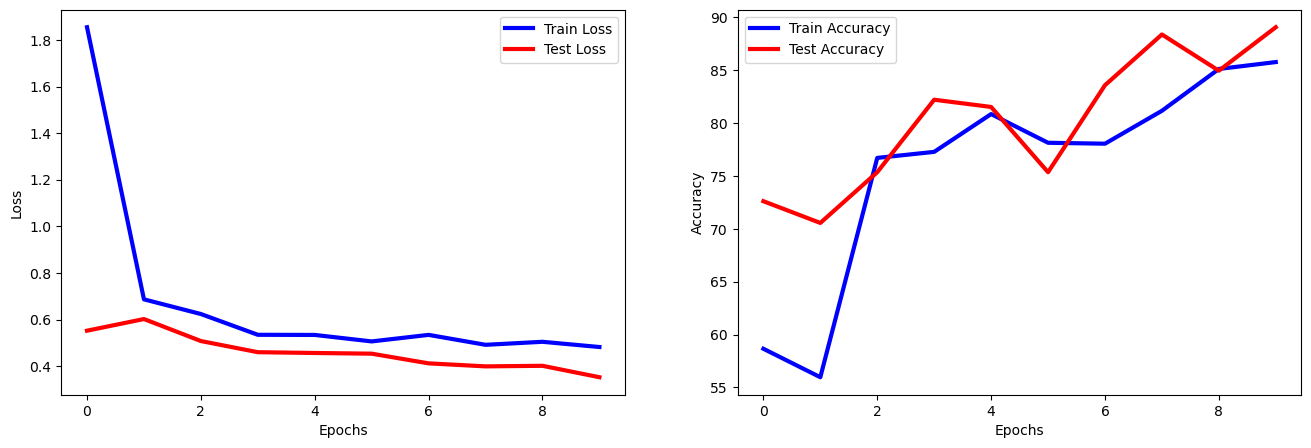

horizontal_flip test accuracy : 
Validation accuracy: 77.4%


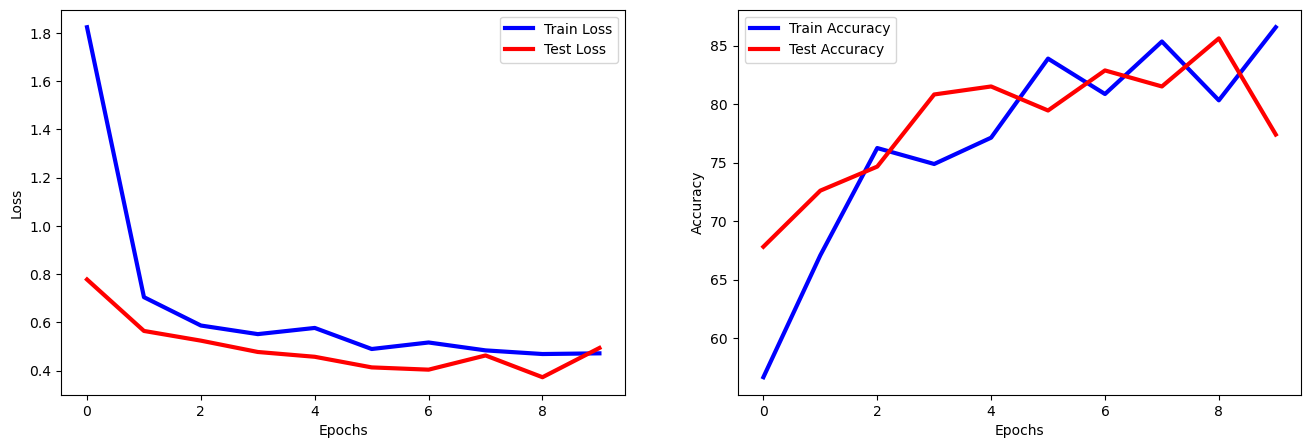

color_jitter test accuracy : 
Validation accuracy: 86.3%


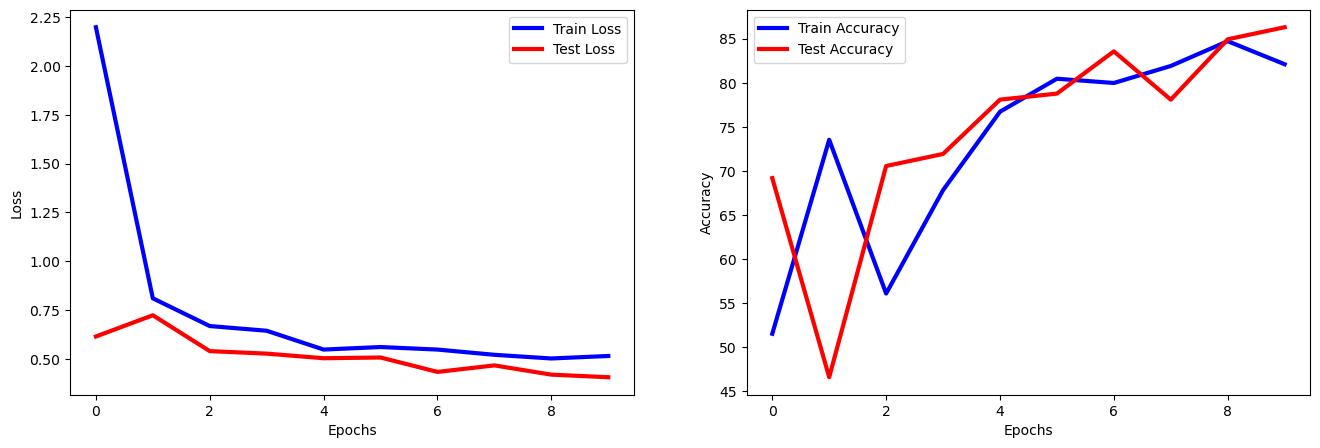

CutMix test accuracy : 
Validation accuracy: 83.56%


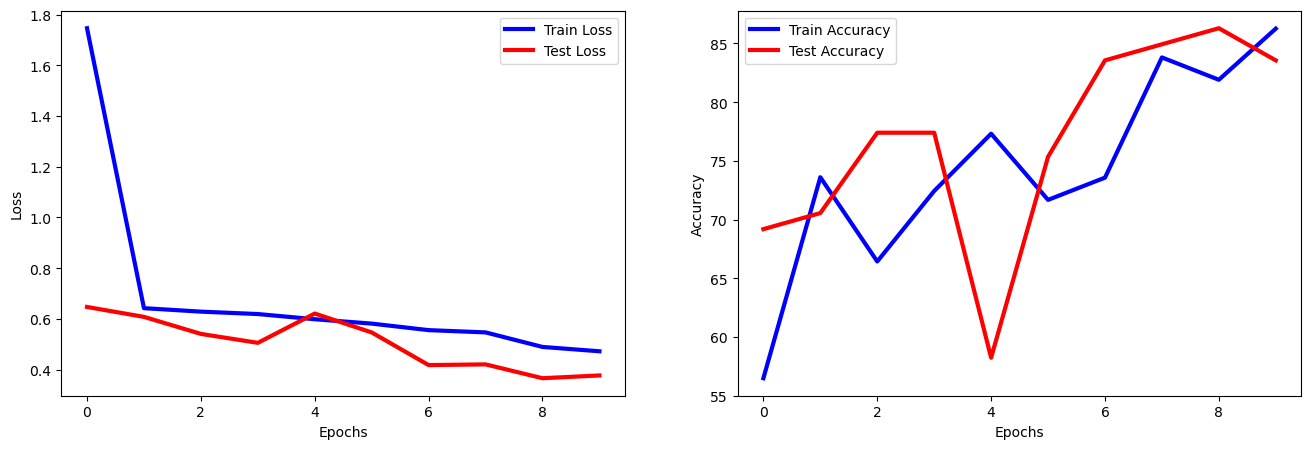

MixUp test accuracy : 
Validation accuracy: 80.14%


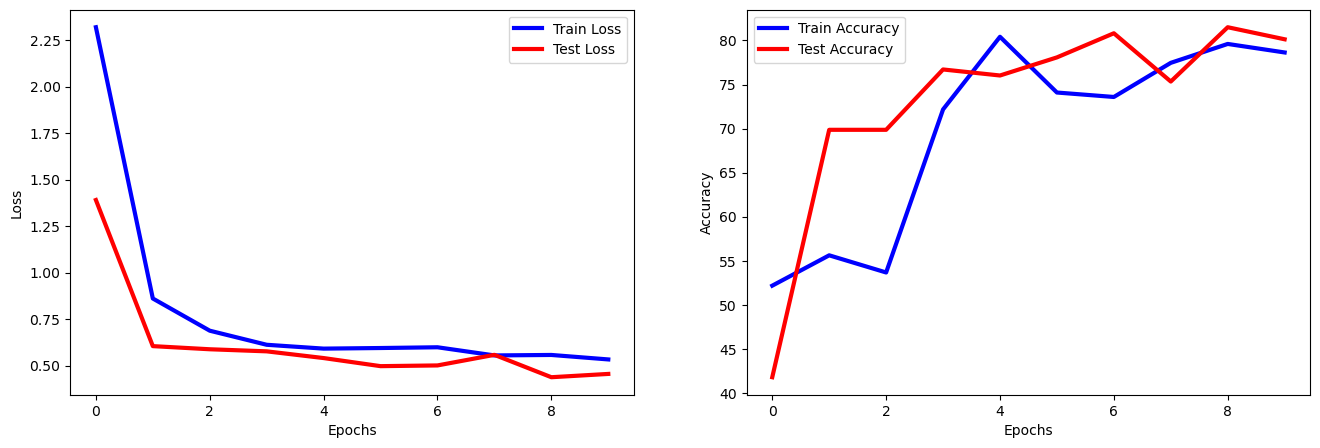

In [12]:
for i, (train_loader, test_loader) in enumerate(zip(trainloaders, testloaders)):
    
    writer = helper.new_writer("ConvNext+augmentation", augmentation_type[i])
    
    convNext = torchvision.models.convnext_base(weights=None)
    convNext.classifier[2] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)    
    
    convNext.to(device)
    convNext.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(convNext.parameters(), lr=0.001)
    
    train = Wrapper(model = convNext,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
    train.train(10,trainloader,testloader,classes)
    print(f"{augmentation_type[i]} test accuracy : ")
    train.valid_accuracy()
    train.plot_loss_acc()
    writer.close()

# Fine-tuning

## Resnet18 

Validation accuracy: 94.52%


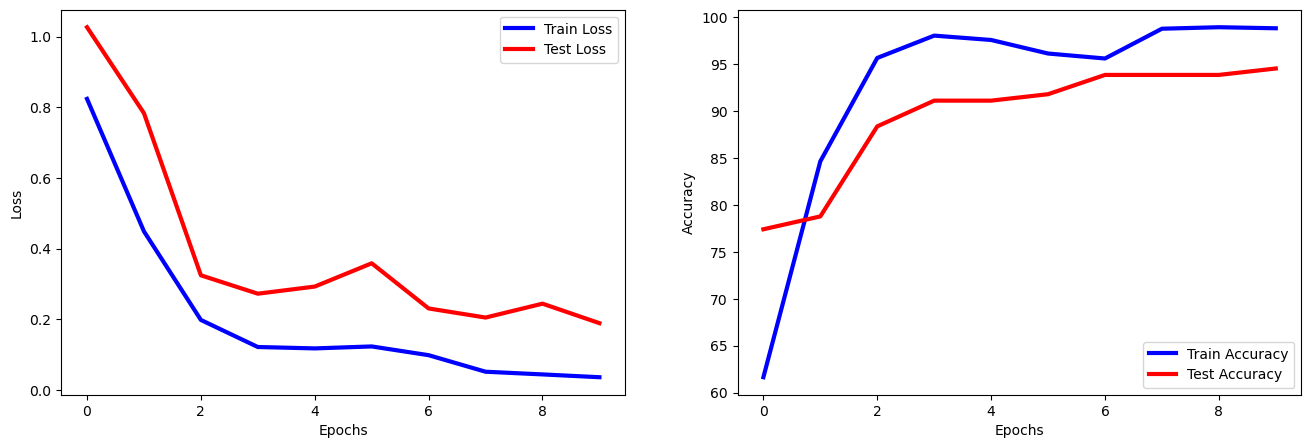

In [13]:
writer = helper.new_writer("fine_tuned","Resnet18")
resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
resnet18.to(device)
resnet18.train()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)
train = Wrapper(model = resnet18,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
train.train(10,trainloaders[0],testloaders[0],classes)
train.valid_accuracy()
train.plot_loss_acc()
writer.close()

## SqueezeNet

Validation accuracy: 51.37%


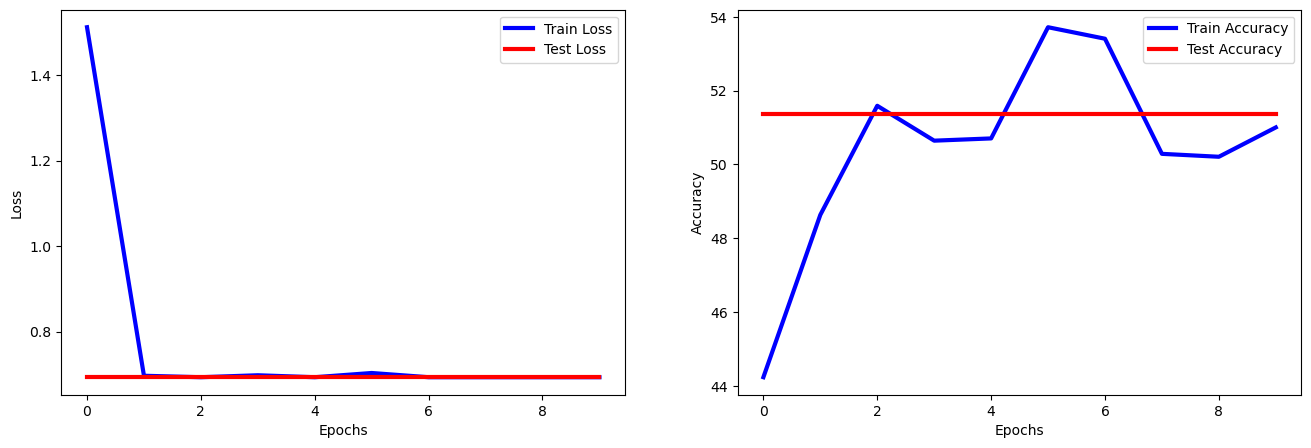

In [14]:
writer = helper.new_writer("fine_tuned","SqueezeNet")
squeezeNet = torchvision.models.squeezenet1_0(weights=torchvision.models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
squeezeNet.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
squeezeNet.to(device)
squeezeNet.train()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(squeezeNet.parameters(), lr=0.001)
train = Wrapper(model = squeezeNet,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
train.train(10,trainloaders[0],testloaders[0],classes)
train.valid_accuracy()
train.plot_loss_acc()
writer.close()

## ConvNext

Validation accuracy: 93.84%


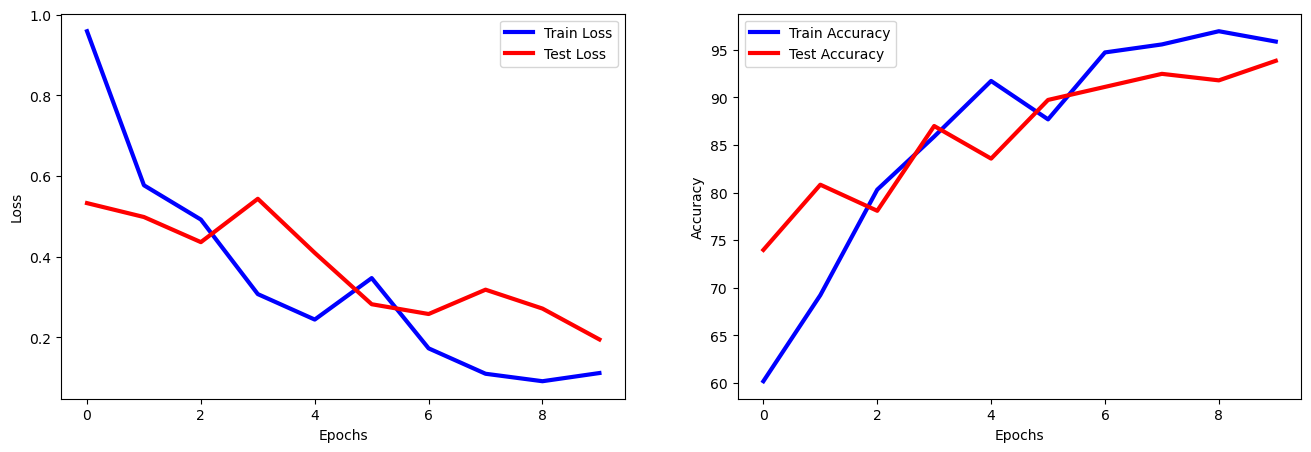

In [17]:
writer = helper.new_writer("fine_tuned","ConvNext")
convNext = torchvision.models.convnext_base(weights=torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1)
convNext.classifier[2] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)
convNext.to(device)
convNext.train()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convNext.parameters(), lr=0.001)
train = Wrapper(model = convNext,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
train.train(10,trainloaders[0],testloaders[0],classes)
train.valid_accuracy()
train.plot_loss_acc()
writer.close()

# Feature extractor

In [18]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

In [19]:
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [20]:
def train_model(model,writer,epochs=10):
    model.to(device)
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train = Wrapper(model = model,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
    train.train(epochs,trainloaders[0],testloaders[0],classes)
    train.valid_accuracy()
    train.plot_loss_acc()
    return train

## ResNet18

Validation accuracy: 82.19%


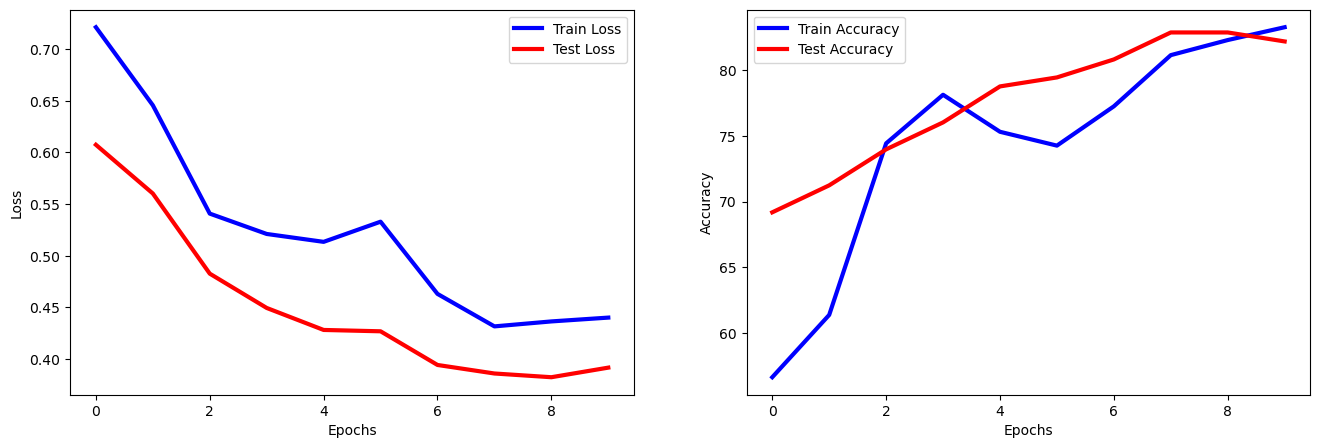

In [22]:
writer = helper.new_writer("feature_extractor","ResNet18")
resnet18_fe = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
# Freezing model parameters
for param in resnet18_fe.parameters():
    param.requires_grad = False
resnet18_fe.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
resnet18_fe.to(device)
resnet18_fe.train()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_fe.parameters(), lr=0.001)
train = Wrapper(model = resnet18_fe,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
train.train(10,trainloaders[0],testloaders[0],classes)
train.valid_accuracy()
train.plot_loss_acc()
writer.close()

## SqueezeNet

Validation accuracy: 51.37%


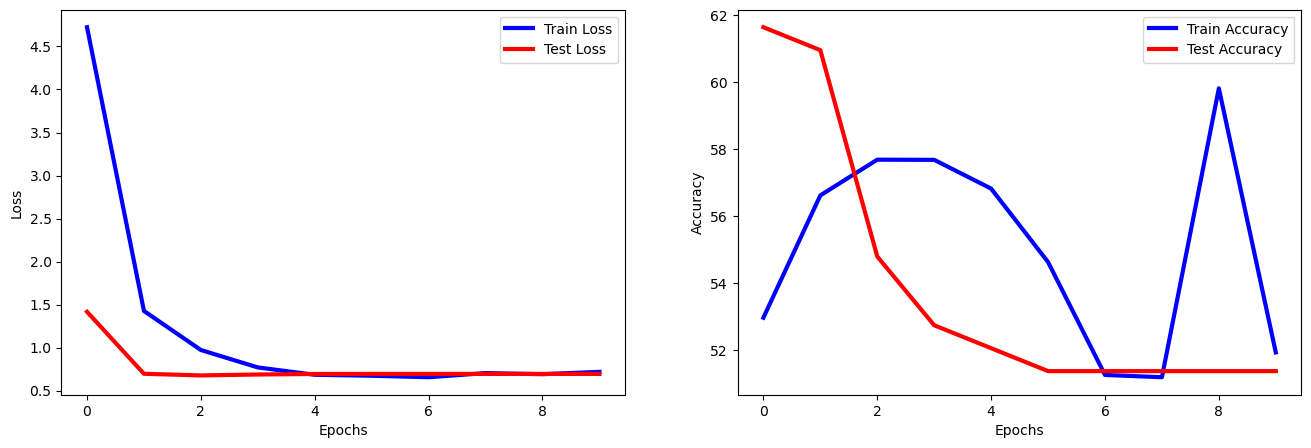

In [23]:
writer = helper.new_writer("feature_extractor","SqueezeNet")
squeezeNet_fe = torchvision.models.squeezenet1_0(weights=torchvision.models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
freeze_model(squeezeNet_fe)
squeezeNet_fe.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
train_squeezeNet = train_model(squeezeNet_fe,writer)
writer.close()

## ConvNext

Validation accuracy: 95.21%


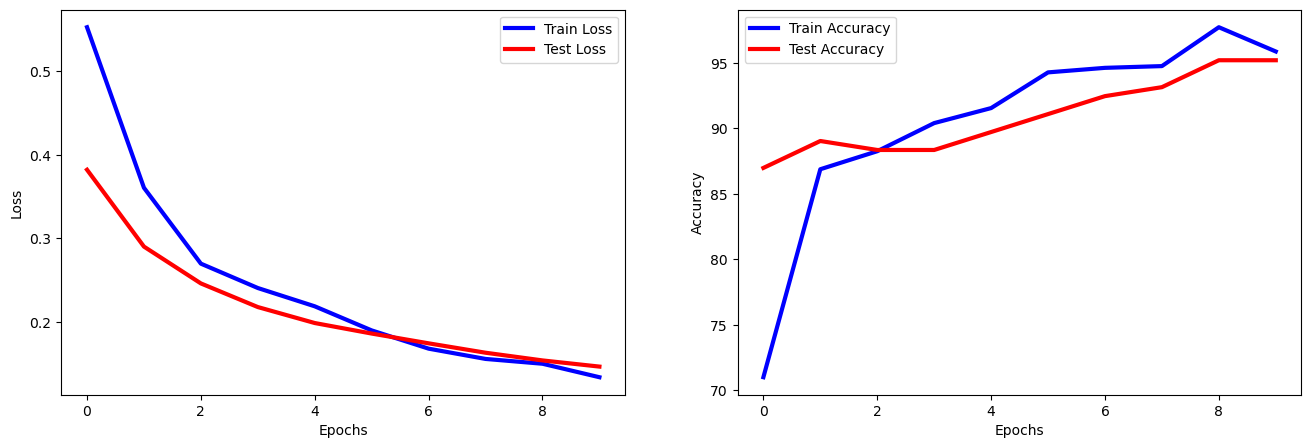

In [24]:
writer = helper.new_writer("feature_extractor","ConvNext")
convNext_fe = torchvision.models.convnext_base(weights=torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1)
freeze_model(convNext_fe)
convNext_fe.classifier[2] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)
train_convNext = train_model(convNext_fe,writer)
writer.close()

# Combined approach

## ResNet18

Validation accuracy: 78.77%


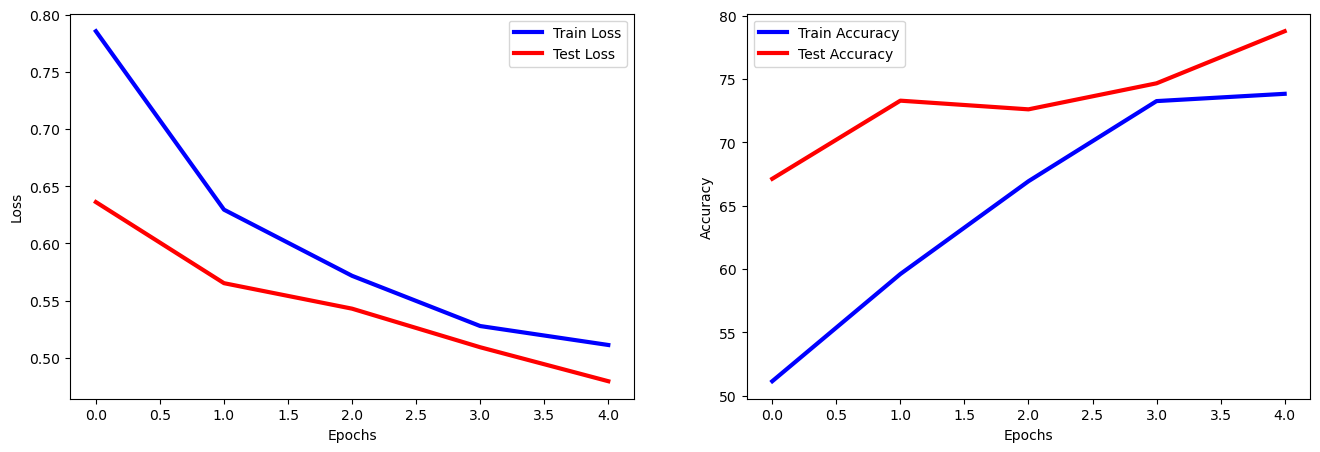

Validation accuracy: 92.47%


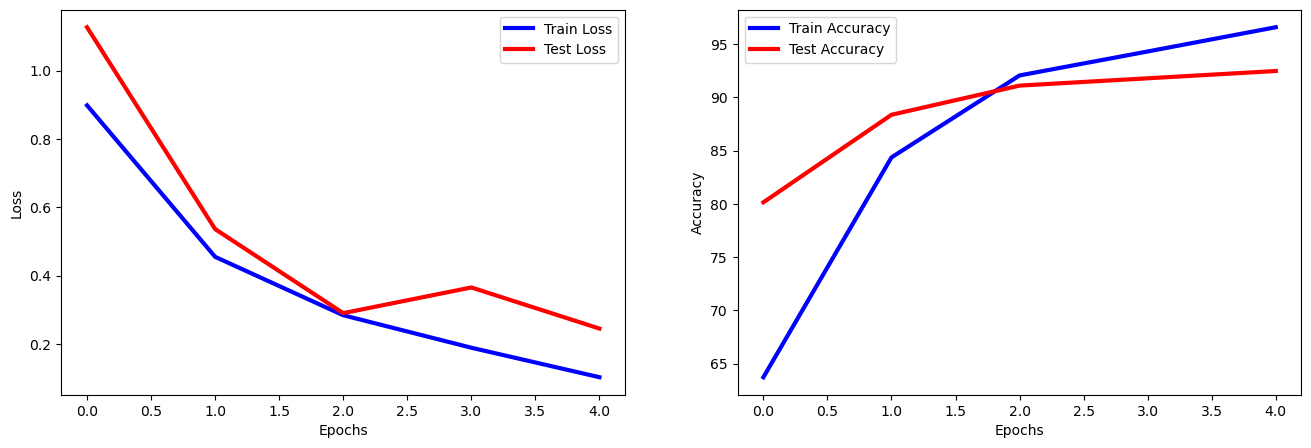

In [25]:
writer = helper.new_writer("Combined_approach","ResNet18")
resnet18_combined = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
freeze_model(resnet18_combined)
resnet18_combined.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
train_model(resnet18_combined,writer, epochs=5)
unfreeze_model(resnet18_combined)
train_resnet18_c = train_model(resnet18_combined,writer, epochs=5)
writer.close()

## SqueezeNet

Validation accuracy: 52.05%


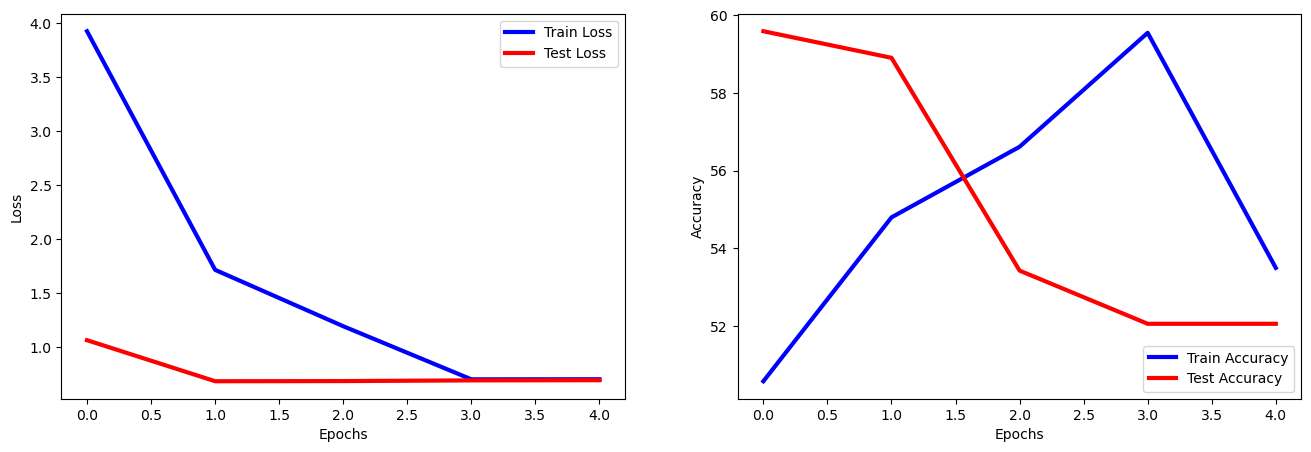

Validation accuracy: 51.37%


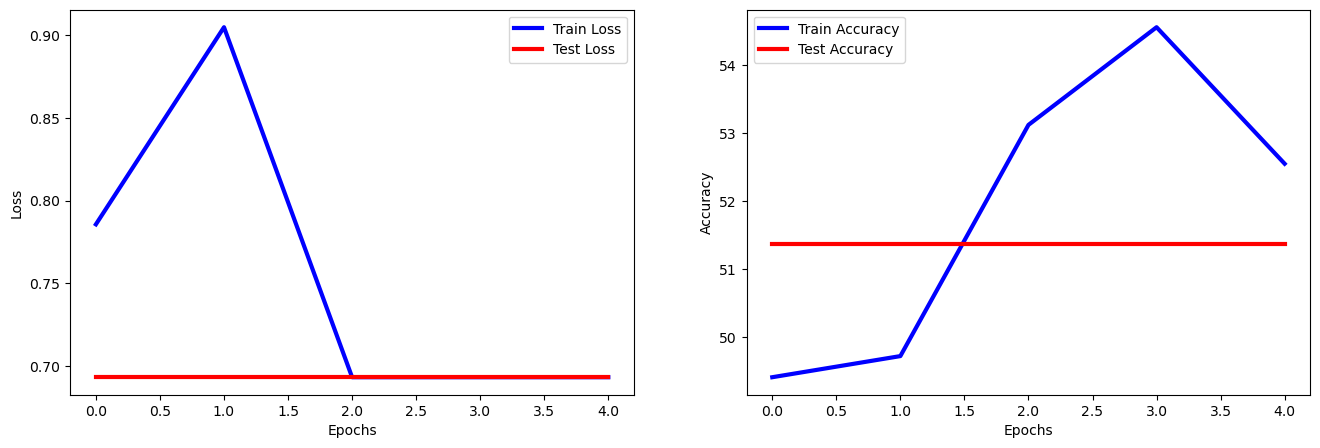

In [26]:
writer = helper.new_writer("Combined_approach","SqueezeNet")
squeezeNet_combined = torchvision.models.squeezenet1_0(weights=torchvision.models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
freeze_model(squeezeNet_combined)
squeezeNet_combined.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
train_model(squeezeNet_combined,writer, epochs=5)
unfreeze_model(squeezeNet_combined)
train_squeezeNet_c = train_model(squeezeNet_combined,writer, epochs=5)
writer.close()

## ConvNext

Validation accuracy: 91.1%


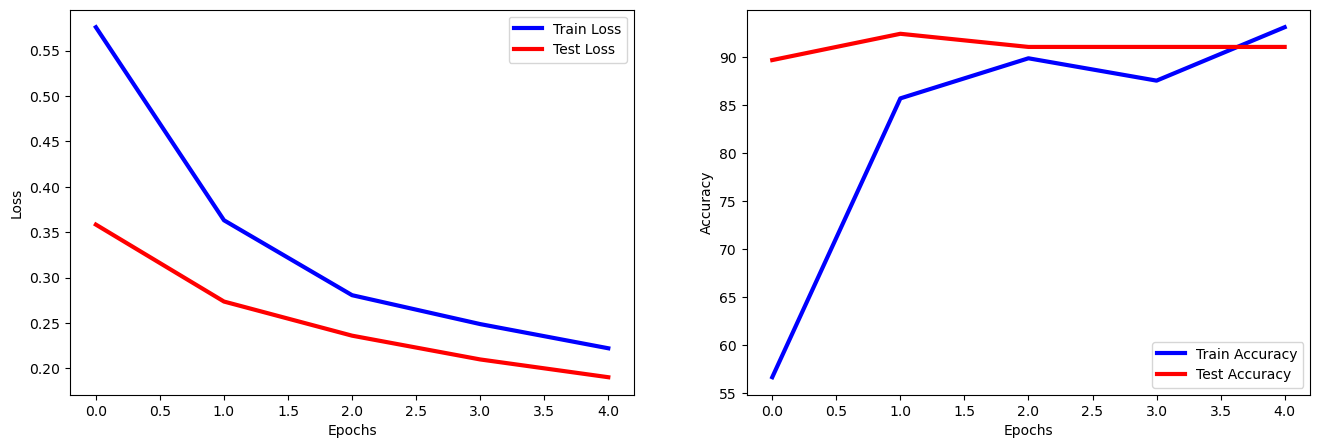

Validation accuracy: 90.41%


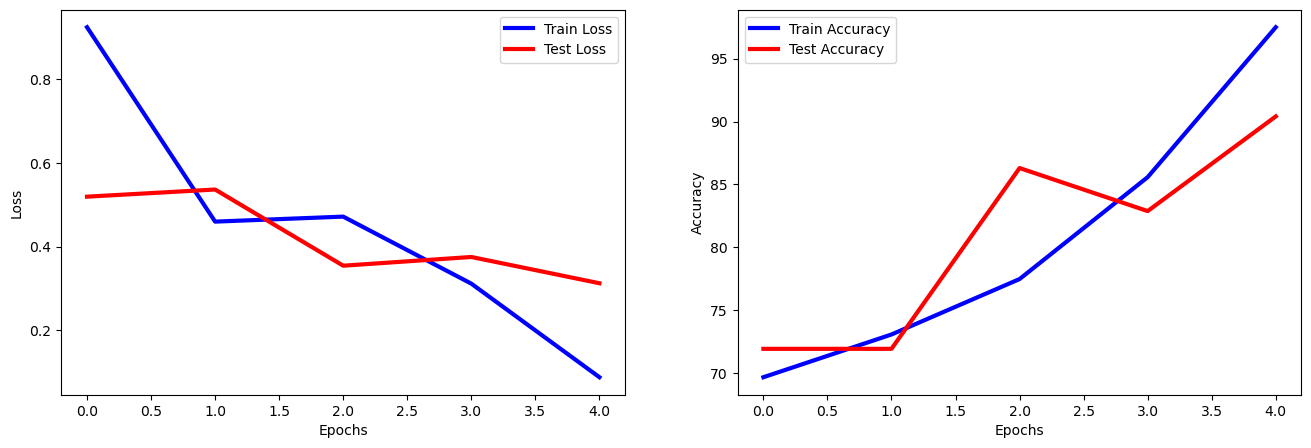

In [27]:
writer = helper.new_writer("Combined_approach","ConvNext")
convNext_combined = torchvision.models.convnext_base(weights=torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1)
freeze_model(convNext_combined)
convNext_combined.classifier[2] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)
train_model(convNext_combined,writer, epochs=5)
unfreeze_model(convNext_combined)
train_convNext_combined = train_model(convNext_combined,writer, epochs=5)
writer.close()